In [2]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('/content/clinical_notes_diagnosis_prediction_5000.csv')
df

,Clinical Notes,Diagnosis
0,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
1,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
2,A 50-year-old male with a history of diabetes ...,Septic Shock
3,"A 35-year-old male presents with heartburn, re...",Gastroesophageal Reflux Disease
4,A 55-year-old female with a history of obesity...,Type 2 Diabetes Mellitus
...,...,...
4995,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4996,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis
4997,A 55-year-old male with a history of heavy alc...,Liver Cirrhosis
4998,"A 40-year-old female presents with swelling, p...",Deep Vein Thrombosis


In [4]:
df['Diagnosis'].value_counts()

,count
Diagnosis,
Peptic Ulcer Disease,284
Type 2 Diabetes Mellitus,283
Acute Myocardial Infarction,272
Chronic Obstructive Pulmonary Disease,269
Cerebrovascular Accident,263
Deep Vein Thrombosis,260
Community-Acquired Pneumonia,251
Chronic Kidney Disease,251
Septic Shock,246


# 1. Data Cleaning and Preprocessing

In [5]:
df['Clinical Notes'][0]

'A 35-year-old male presents with heartburn, regurgitation, and a sour taste in his mouth, especially after meals. The patient has been self-medicating with over-the-counter antacids, but the symptoms persist. A 24-hour pH monitoring test confirms the diagnosis of GERD. The patient is started on a PPI and advised to avoid trigger foods.'

In [6]:
import re
import nltk
from nltk.corpus import stopwords

In [7]:
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [8]:
def clean_statement(text):

  # lower casing
  text = str(text).lower()
  text = re.sub(r'\d+','',text)

  # keep only latters
  text = re.sub(r'[^a-zA-Z\s]','', text)
  text = re.sub(r'\s+',' ', text)

  # Tokenization (spliting)
  words = text.split()
  words = [word for word in words if word not in stop_words]

  return ' '.join(words)

df['Clinical Notes'] = df['Clinical Notes'].apply(clean_statement)

In [9]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])

In [10]:
df.head()

,Clinical Notes,Diagnosis
0,yearold male presents heartburn regurgitation ...,9
1,yearold male history heavy alcohol use present...,11
2,yearold male history diabetes presents hypoten...,16
3,yearold male presents heartburn regurgitation ...,9
4,yearold female history obesity hypertension pr...,18


# 2. Tokenization

In [11]:
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(df['Clinical Notes'],df['Diagnosis'], test_size=0.2, random_state=42)

In [12]:
train_texts.shape

(4000,)

In [13]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(list(train_texts), padding=True, truncation=True, max_length=512)
test_encodings = tokenizer(list(test_texts), padding=True, truncation=True, max_length=512)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [19]:
from datasets import Dataset

train_dataset = Dataset.from_dict({'input_ids':train_encodings['input_ids'],
                                  'attention_mask':train_encodings['attention_mask'],
                                   'labels': train_labels.tolist()})
test_dataset = Dataset.from_dict({'input_ids':test_encodings['input_ids'],
                                 'attention_mask':test_encodings['attention_mask'],
                                  'labels': test_labels.tolist()})

# Fine Tune model

In [20]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

training_args = TrainingArguments(
    output_dir = './results2',
    eval_strategy ='epoch',
    save_strategy ='epoch',
    learning_rate = 2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay = 0.01,
    logging_dir = './logs',
    logging_steps = 10,
    lr_scheduler_type = 'linear',
    warmup_steps = 500,
    load_best_model_at_end=True,
    metric_for_best_model='eval_loss',
    save_total_limit=3,
    gradient_accumulation_steps=2
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset = train_dataset,
    eval_dataset = test_dataset
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,2.364200,2.203844
2,1.110600,0.941198
3,0.206300,0.136697
4,0.038600,0.026848
5,0.024000,0.017661


TrainOutput(global_step=625, training_loss=1.0232249735116958, metrics={'train_runtime': 350.4074, 'train_samples_per_second': 57.076, 'train_steps_per_second': 1.784, 'total_flos': 668163381600000.0, 'train_loss': 1.0232249735116958, 'epoch': 5.0})

# Evaluation

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
predictions, labels, _ = trainer.predict(test_dataset)
predicted_labels = np.argmax(predictions, axis=1)

In [24]:
# make sure the 'label_encoder.classes_' are passed as string labels
target_names = [str(label) for label in label_encoder.classes_]

print(classification_report(test_labels, predicted_labels, target_names=target_names))


                                       precision    recall  f1-score   support

          Acute Myocardial Infarction       1.00      1.00      1.00        51
                  Acute Renal Failure       1.00      1.00      1.00        57
                               Asthma       1.00      1.00      1.00        53
             Cerebrovascular Accident       1.00      1.00      1.00        53
               Chronic Kidney Disease       1.00      1.00      1.00        40
Chronic Obstructive Pulmonary Disease       1.00      1.00      1.00        51
         Community-Acquired Pneumonia       1.00      1.00      1.00        48
             Congestive Heart Failure       1.00      1.00      1.00        56
                 Deep Vein Thrombosis       1.00      1.00      1.00        50
      Gastroesophageal Reflux Disease       1.00      1.00      1.00        50
                         Hypertension       1.00      1.00      1.00        40
                      Liver Cirrhosis       1.00   

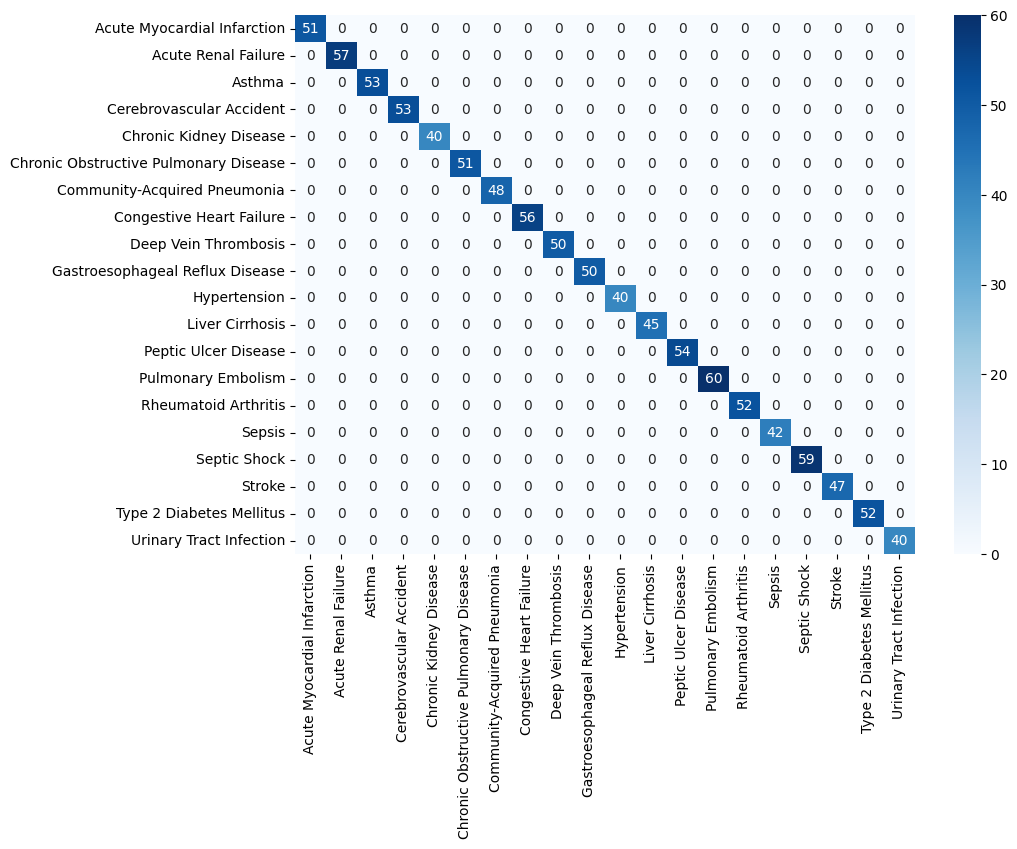

In [25]:
cm = confusion_matrix(test_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)

plt.show()

# Save model

In [26]:
trainer.save_model("./Clinical_Diagnosis_Predictiont_bert")
trainer.save_state()
tokenizer.save_pretrained("./Clinical_Diagnosis_Predictiont_bert")

('./Clinical_Diagnosis_Predictiont_bert/tokenizer_config.json',
 './Clinical_Diagnosis_Predictiont_bert/special_tokens_map.json',
 './Clinical_Diagnosis_Predictiont_bert/vocab.txt',
 './Clinical_Diagnosis_Predictiont_bert/added_tokens.json')

In [27]:
!zip -r Clinical_Diagnosis_Predictiont_bert.zip Clinical_Diagnosis_Predictiont_bert/

  adding: Clinical_Diagnosis_Predictiont_bert/ (stored 0%)
  adding: Clinical_Diagnosis_Predictiont_bert/special_tokens_map.json (deflated 42%)
  adding: Clinical_Diagnosis_Predictiont_bert/vocab.txt (deflated 53%)
  adding: Clinical_Diagnosis_Predictiont_bert/training_args.bin (deflated 52%)
  adding: Clinical_Diagnosis_Predictiont_bert/model.safetensors (deflated 7%)
  adding: Clinical_Diagnosis_Predictiont_bert/tokenizer_config.json (deflated 75%)
  adding: Clinical_Diagnosis_Predictiont_bert/config.json (deflated 62%)


In [28]:
from google.colab import files
files.download("Clinical_Diagnosis_Predictiont_bert.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Save to file
import pickle

pickle.dump(label_encoder, open('label_encoder.pkl','wb'))

# Load model

In [30]:
from transformers import BertForSequenceClassification, BertTokenizer

# Load the model and tokenizer from the saved paths
model = BertForSequenceClassification.from_pretrained("Clinical_Diagnosis_Predictiont_bert")
tokenizer = BertTokenizer.from_pretrained("Clinical_Diagnosis_Predictiont_bert")

with open('label_encoder.pkl','rb') as f:
  label_encoder = pickle.load(f)


# Prediction

In [31]:
import torch

def predict_disease(patient_note, model, tokenizer, label_encoder):
  patient_note = clean_statement(patient_note)
  inputs = tokenizer(patient_note, return_tensors='pt', padding=True, truncation=True, max_length=512)

  with torch.no_grad():
    output = model(**inputs)
    logits = output.logits
    predicted_label = torch.argmax(logits, dim=1).item()

  return label_encoder.inverse_transform([predicted_label])

In [32]:
patient_note = 'Patient presents with fever, headache, and fatigue. Medical history includes hypertension.'

# make_prediction
predicted_disease = predict_disease(patient_note, model, tokenizer, label_encoder)

# print the prediction
print('Predicted Disease: ',predicted_disease)

Predicted Disease:  ['Acute Renal Failure']
